### Train a PPO agent

In [1]:
%run ppo_sagin_v1_1.py

Training episode 0                      
Episodic Return: -0.9999999999999997    
Episode Length: 127                     
                                        
Value Loss: 7.5009352648014795          
Policy Loss: 3.642405255896208          
Old Approx KL: -0.003807056563079003    
Approx KL: 0.0015397986419550622        
Clip Fraction: 0.023617097694012854     
Explained Variance: -0.003713003877155785
                                        
-------------------------------------------

Training episode 1                              
Episodic Return: 6.599999999999999              
Episode Length: 127                             
                                                
Value Loss: 46.42154748507481                   
Policy Loss: -8.469897097556672                 
Old Approx KL: 0.022785033556954947             
Approx KL: 0.005952018419284622                 
Clip Fraction: 0.1477789752599266               
Explained Variance: -0.0014635304966030827      
             

##### Save the trained agent

In [15]:
# import os
# import datetime
# import torch

# PATH = "trained_agents/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# os.makedirs(PATH)

# metadata = {
#     "name": "ppo_sagin_v1_1",
#     'episode': total_episodes,
# }

# model = agent.network
# torch.save({
#             'episode': total_episodes,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'log_ep_return': log_ep_return,
#             'log_value_loss': log_value_loss,
#             'log_policy_loss': log_policy_loss,
#             "metadata": metadata
#             }, PATH + "/model.tar")

# with open(os.path.join(PATH, "metadata.txt"), 'w') as f: 
#     for key, value in metadata.items(): 
#         f.write('%s: %s\n' % (key, value)) 

# print(f"Saved the trained agent to {PATH}")

Saved the trained agent to trained_agents/20240316-152137


##### Training KPIs

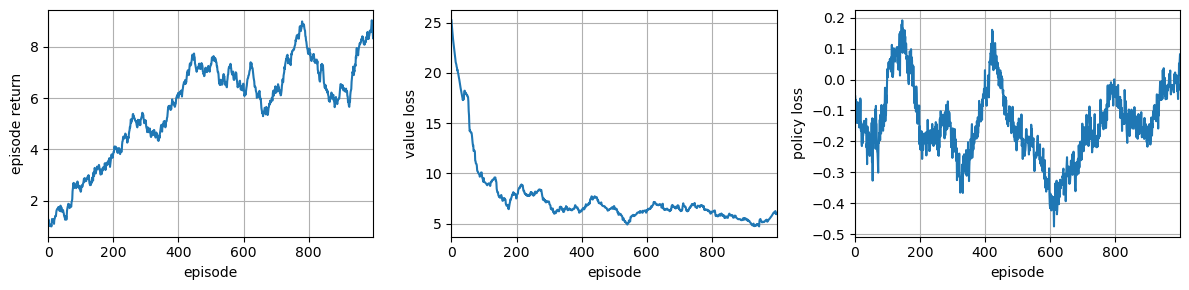

In [2]:
import pandas as pd

window = 100

df = pd.DataFrame({
        'episode return': log_ep_return,
        'value loss': log_value_loss,
        'policy loss': log_policy_loss
})

fig, axs = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(12,3))
for i, col in enumerate(df.columns):
        # axs[i].plot(df[col])
        axs[i].plot(df[col].rolling(window=window, min_periods=1, center=True).mean())
        axs[i].set_xlabel('episode')
        axs[i].set_ylabel(col)
        axs[i].margins(x=0)
        axs[i].grid(True)
        fig.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "tmp", f"training.png"))
plt.show()
plt.close()

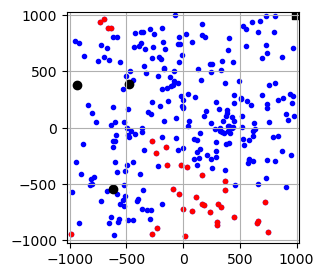

In [3]:
""" PLOTTING """
mbs_locs = env.unwrapped.locs['mbs']
user_locs = env.unwrapped.locs['user']
uav_locs = env.unwrapped.locs['uav']
satisfied = env.unwrapped.infos['global']['drates'] <= env.unwrapped.drate_threshold
user_locs_2 = env.unwrapped.locs['user'][:, satisfied]

fig = plt.figure(figsize=(3,3))
axs = fig.gca()
axs.set_xlim(-1000-25, 1000+25)
axs.set_ylim(-1000-25, 1000+25)
axs.grid(True)
axs.scatter(user_locs[0], user_locs[1], marker=".", color='b')
axs.scatter(user_locs_2[0], user_locs_2[1], marker=".", color='r')
axs.scatter(uav_locs[0], uav_locs[1], marker='o', color='k')
axs.scatter(mbs_locs[0], mbs_locs[1], marker='s', color='k')
fig.savefig("tmp/trajectory.png")
plt.show()

### Test the trained agent

##### Movements of UAVs

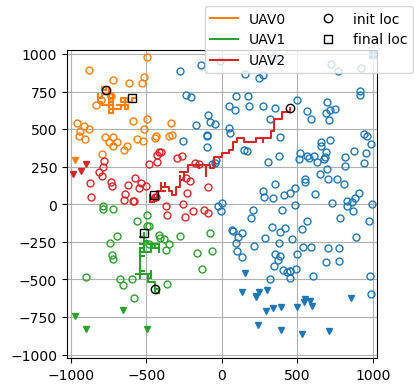

In [7]:
import matplotlib.colors as mcolors

""" RENDER THE POLICY """
env = parallel_env(seed=None, max_cycles=128)
# env = color_reduction_v0(env)
# env = resize_v1(env, 64, 64)
# env = frame_stack_v1(env, stack_size=4)

agent.eval()

n_episodes = 1
log_uav_locs = []

with torch.no_grad():
    # render some episodes out
    for episode in range(n_episodes):
        obs, infos = env.reset(seed=None)
        obs = batchify_obs(obs, device)
        terms = [False]
        truncs = [False]
        while not any(terms) and not any(truncs):
            # loggging
            log_uav_locs.append(env.unwrapped.locs['uav'].copy())

            actions, logprobs, _, values = agent.get_action_and_value(obs)
            obs, rewards, terms, truncs, infos = env.step(unbatchify(actions, env))
            obs = batchify_obs(obs, device)
            terms = [terms[a] for a in terms]
            truncs = [truncs[a] for a in truncs]

        env.close()

""" PLOTTING """
mbs_locs = env.unwrapped.locs['mbs']
log_uav_locs = np.array(log_uav_locs)       # shape = (n_steps, 2, n_uavs)
user_locs = env.unwrapped.locs['user']
n_mbss = mbs_locs.shape[-1] 
n_uavs = log_uav_locs.shape[-1]
n_users = user_locs.shape[-1]

satisfied = env.unwrapped.infos['global']['drates'] >= env.unwrapped.drate_threshold
bs_mapping = env.unwrapped.infos['global']['bs_mapping']

markers = {True: "o", False: "v"}       # satisfied vs unsatisfied
mfcs = {True: "None", False: ""}        # satisfied vs unsatisfied
colors = list(mcolors.TABLEAU_COLORS)   # encoded for different base stations

fig = plt.figure(figsize=(4,4))
axs = fig.gca()
axs.set_xlim(-1000-25, 1000+25)
axs.set_ylim(-1000-25, 1000+25)
axs.grid(True)

for mbs_id in range(n_mbss):
    axs.scatter(mbs_locs[0][mbs_id], mbs_locs[1][mbs_id],
                marker='s', color=colors[mbs_id])

for i in range(n_users):
    # axs.scatter(user_locs[0][i], user_locs[1][i], s=15,
    #             marker=markers[satisfied[i]], color=colors[bs_mapping[i]])
    if satisfied[i] == True:
        axs.plot(user_locs[0][i], user_locs[1][i], marker=markers[satisfied[i]],
                markerfacecolor="None", color=colors[bs_mapping[i]], markersize=5)
    else: 
        axs.plot(user_locs[0][i], user_locs[1][i], marker=markers[satisfied[i]],
                color=colors[bs_mapping[i]], markersize=5)
    
for uav_id in range(n_uavs):
    loc_uav = log_uav_locs[:, :, uav_id].transpose()
    axs.plot(loc_uav[0], loc_uav[1], color=colors[n_mbss + uav_id], label=f"UAV{uav_id}")
    if uav_id == n_uavs - 1:
        l_init, l_final = "init loc", "final loc"
    else:
        l_init, l_final = "", ""
    axs.plot(loc_uav[0][0], loc_uav[1][0], 'ok',
             markerfacecolor="None", label=l_init) # mec=colors[n_mbss + uav_id]
    axs.plot(loc_uav[0][-1], loc_uav[1][-1], 'sk',
             markerfacecolor="None", label=l_final) # mec=colors[n_mbss + uav_id]

fig.legend(ncol=2)
fig.savefig("tmp/trajectory.png")
plt.show()

##### Observations of agents

Image saved to /mnt/newdiskpartition/uavbs-placement-marl/code/tmp/uav_0.png
Image saved to /mnt/newdiskpartition/uavbs-placement-marl/code/tmp/uav_1.png
Image saved to /mnt/newdiskpartition/uavbs-placement-marl/code/tmp/uav_2.png


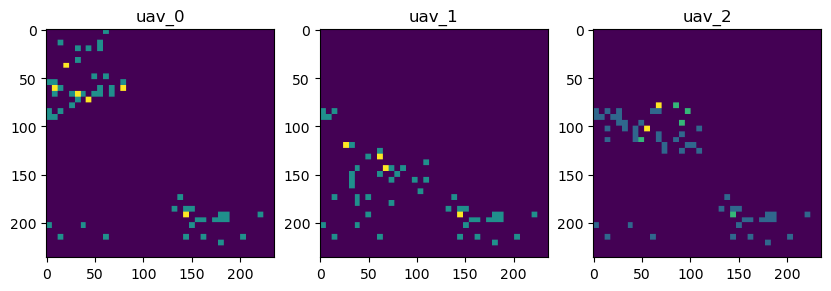

In [8]:
# env = parallel_env(seed=30, max_cycles=100)
# env.reset()
# hms = {}
# for uav in env.agents:
#     hms[uav] = env.unwrapped.observe(uav)[8:].reshape(40, -1)

obs_last = unbatchify(obs, env)
hms = {}
for uav in obs_last.keys():
    hms[uav] = obs_last[uav][8:].reshape(40, -1)

for uav, hm in hms.items():
    save_img_from_rgba_arr(hm,  figsize=(4,4), dpi=64, transparent=False, fpath=f"tmp/{uav}.png")

env.close()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for i, uav in enumerate(hms.keys()):
    im = plt.imread(f"tmp/{uav}.png")
    axs[i].imshow(im)
    axs[i].set_title(f"{uav}")
plt.show()

In [6]:
'''Check the total params of the NN'''
# agent = Agent(num_actions=num_actions).to(device)
model = agent.network

# Ref: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('total params: %s M'%(pytorch_total_params/1e6))

total params: 2.172416 M
